In [139]:
# import dependencies
import pandas as pd
import json
import requests
from googleapiclient.discovery import build
from config import api_key
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

In [140]:
# Enter video id
# Snarky Puppy - Trinity
video_id = "CSiLPkUopBg"

In [141]:
def video_comments_to_df(video_id):
    # creating youtube resource object
    youtube = build('youtube', 'v3', developerKey=api_key)
    
    # retrieve youtube video results
    video_response = youtube.commentThreads().list(part='snippet,replies', videoId=video_id).execute()

    # create empty dataframe
    df = pd.DataFrame(columns=['id', 'author', 'thumbsup', 'text', '# of replies', 'replies'])

    # iterate video response
    while video_response:

    # export comments to a dataframe
        for i in range(len(video_response['items'])):
            replies = []
            id = video_response['items'][i]['snippet']['topLevelComment']['id']
            author = video_response['items'][i]['snippet']['topLevelComment']['snippet']['authorDisplayName']
            text = video_response['items'][i]['snippet']['topLevelComment']['snippet']['textOriginal']
            replycount = video_response['items'][i]['snippet']['totalReplyCount']
            if replycount>0:
                for reply in video_response['items'][i]['replies']['comments']:
                    reply = reply['snippet']['textOriginal']
                    replies.append(reply)
            df = df.append({
                'id': id, 
                'author': author, 
                'thumbsup': int(video_response['items'][i]['snippet']['topLevelComment']['snippet']['likeCount']),
                'text': text, 
                '# of replies': replycount, 
                'replies': replies 
                }, 
                ignore_index=True)
        if 'nextPageToken' in video_response:
            video_response = youtube.commentThreads().list(
            part='snippet,replies',
            videoId=video_id,
            pageToken=video_response['nextPageToken']
            ).execute()
        else:
            break

    # change data types
    df['thumbsup'] = df['thumbsup'].astype(int)
    df['# of replies'] = df['# of replies'].astype(int)

    return df

In [142]:
df = video_comments_to_df(video_id)

In [143]:
# export to csv
df.to_csv('comments.csv', index=False)


In [144]:
# total reply checker

# for "Trinity", total replies should be >1868
total_replies = len(df) + sum(df['# of replies'])
print(f'Total replies: {total_replies}')

# SUCCESS


Total replies: 1871


In [145]:
print(len(df['author'].unique()))

1233


In [146]:
df['author'].value_counts()

sc pk                                      4
Musicadamata                               4
Uncle Steven T.V.                          3
João Paulo                                 3
SkonrokkenTV                               3
                                          ..
StaticSmile                                1
Go Bucks                                   1
Tymas Seun                                 1
Daniel Waeber                              1
Miguel Márquez - Guitarist and Composer    1
Name: author, Length: 1233, dtype: int64

In [147]:
# get sentiment of comments
analyzer = SentimentIntensityAnalyzer()

In [148]:
comments = df['text'].to_list()
compound_values_list = []
positive_values_list = []
negative_values_list = []
neutral_values_list = []
for comment in comments:
    compound = analyzer.polarity_scores(comment)['compound']
    compound_values_list.append(compound)
    pos = analyzer.polarity_scores(comment)['pos']
    positive_values_list.append(pos)
    neg = analyzer.polarity_scores(comment)['neg']
    negative_values_list.append(neg)
    neu = analyzer.polarity_scores(comment)['neu']
    neutral_values_list.append(neu)
df['compound'] = compound_values_list
df['positive'] = positive_values_list
df['negative'] = negative_values_list
df['neutral'] = neutral_values_list
print(df['compound'].mean())
print(len(df['compound'] ))

0.30241490015360983
1302


In [149]:
# drop rows where compound and neutral are 0
df = df.drop(df[(df['compound'] == 0) & (df['neutral'] == 1)].index)

In [163]:
# plot the data
def plot(df, bin_count):
    plt.figure(figsize=(10, 6))
    plt.hist(df, bins=bin_count)
    plt.xlabel('Compound Sentiment')
    plt.ylabel('Number of Comments')
    plt.title('Sentiment Analysis of Snarky Puppy - Trinity')
    plt.show()


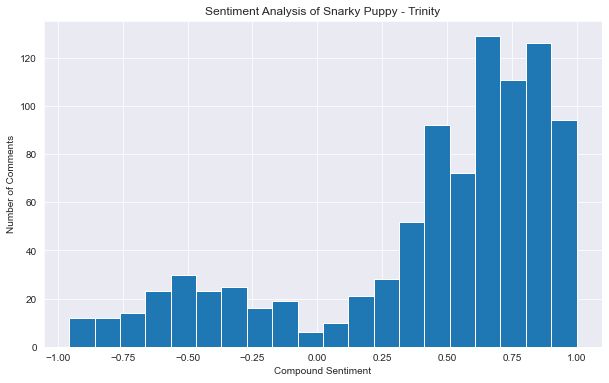

In [164]:
plot(df['compound'], 20)

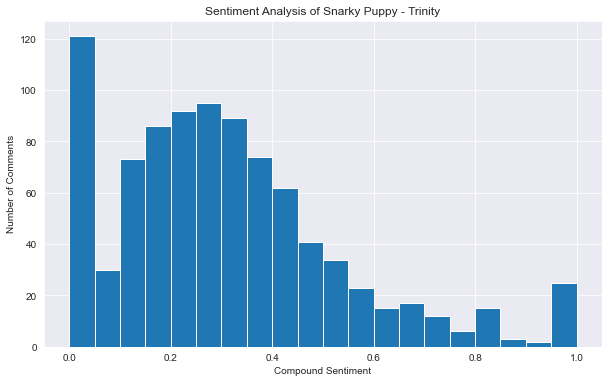

In [158]:
plot(df['positive'], 20)

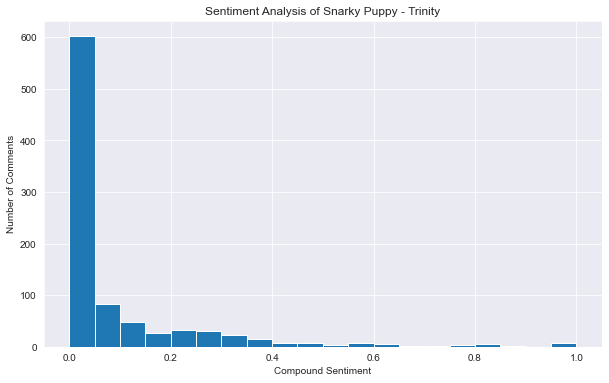

In [159]:
plot(df['negative'], 20)

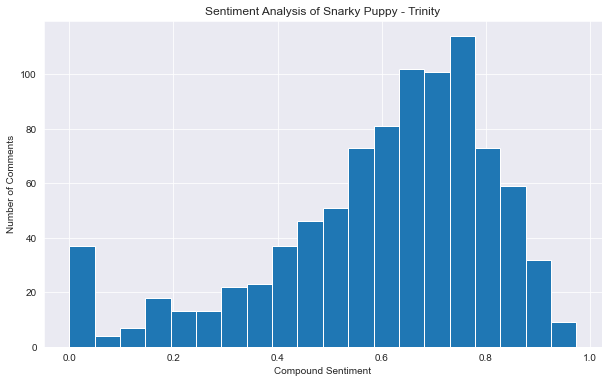

In [160]:
plot(df['neutral'], 20)